In [5]:
# Python 3.10+; pip install networkx numpy torch
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
from collections import defaultdict

import numpy as np
import torch
import networkx as nx



@dataclass
class Config:
    num_nodes: int = 32           # number of nodes
    edge_prob: float = 0.1        # Erdos-Renyi p
    walk_length: int = 10          # L
    traj_per_start: int = 1000      # 100 trajectories from each start node
    max_steps_plan: int = 32       # EN planning step cap
    seed: int = 50                 # reproducibility


# -----------------------------
# 1) GRAPH + TRAJECTORY GENERATION
# -----------------------------
def make_graph(cfg: Config) -> nx.Graph:
    rng = np.random.default_rng(cfg.seed)
    G = nx.erdos_renyi_graph(n=cfg.num_nodes, p=cfg.edge_prob, seed=cfg.seed, directed=False)
    # Ensure no isolated nodes (optional but helpful for walks); reconnect if needed
    # If you prefer to allow isolates, comment the block below.
    if not nx.is_connected(G):
        # Connect components minimally to avoid trivial disconnections
        comps = list(nx.connected_components(G))
        for i in range(len(comps) - 1):
            u = random.choice(list(comps[i]))
            v = random.choice(list(comps[i+1]))
            G.add_edge(u, v)
    return G


def random_walk_from(G: nx.Graph, start: int, L: int, rng: random.Random) -> List[int]:
    """Uniform random walk of length L (returns L+1 node indices including start)."""
    path = [start]
    current = start
    for _ in range(L):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break  # dead end
        current = rng.choice(neighbors)
        path.append(current)
    return path


def generate_trajectories(G: nx.Graph, cfg: Config) -> List[List[int]]:
    """Create 100 * 100 trajectories (traj_per_start per node)."""
    rng = random.Random(cfg.seed)
    trajectories: List[List[int]] = []
    for s in range(cfg.num_nodes):
        for _ in range(cfg.traj_per_start):
            traj = random_walk_from(G, s, cfg.walk_length, rng)
            trajectories.append(traj)
    return trajectories


# -----------------------------
# 2) BUILD Q MATRIX
# -----------------------------
def build_Q(trajectories: List[List[int]], num_nodes: int) -> torch.Tensor:
    """
    Q shape = (num_trajectories, num_nodes).
    Entry is 1 if node appears at least once in that trajectory, else 0.
    """
    n_traj = len(trajectories)
    Q = torch.zeros((n_traj, num_nodes), dtype=torch.uint8)
    for i, traj in enumerate(trajectories):
        # unique node indices in the trajectory
        nodes = np.fromiter(set(traj), dtype=np.int64)
        Q[i, torch.from_numpy(nodes)] = 1
    return Q


# -----------------------------
# 3) CORRELATION BETWEEN NODE EMBEDDINGS
# -----------------------------
def columnwise_dot_corr_matrix(Q_bin: torch.Tensor) -> torch.Tensor:
    """
    Returns N×N dot product similarity between node embeddings.
    Q_bin is uint8 {0,1}; convert to float.
    """
    X = Q_bin.float()  # shape (T, N)
    C = X.T @ X        # shape (N, N), raw dot products
    return C


# -----------------------------
# 4) EN PLANNING (GREEDY BY CORR TO GOAL)
# -----------------------------

def en_plan_single(
    G: nx.Graph,
    corr: torch.Tensor,
    start: int,
    goal: int,
    max_steps: int,
    diag: bool
) -> Tuple[bool, int]:
    """
    Greedy EN policy:
      - If current node has the goal as a neighbor, move there immediately.
      - Else, pick neighbor v maximizing dot product corr[v, goal].
    Constraint: do not reuse the same directed action (u -> v) during this plan.
    Stops on reaching goal, when no valid move exists, or step cap reached.
    Returns (success, steps_taken_if_success_else_0).
    """
    if start == goal:
        return True, 0

    used_actions: Set[Tuple[int, int]] = set()
    current = start
    steps = 0

    for _ in range(max_steps):
        if current == goal:
            return True, steps

        neighbors = list(G.neighbors(current))
        # 1) direct goal check
        if goal in neighbors and (current, goal) not in used_actions:
            steps += 1
            return True, steps

        # 2) filter used actions
        candidates = [v for v in neighbors if (current, v) not in used_actions]
        if not candidates:
            break

        # 3) pick by max dot product with goal
        with torch.no_grad():
            scores = corr[candidates, goal].cpu().numpy()
        nxt = candidates[int(np.argmax(scores))]

        used_actions.add((current, nxt))
        current = nxt
        steps += 1

    return (current == goal, steps if current == goal else 0)



def dijkstra_length(G: nx.Graph, s: int, t: int):
    """Unweighted shortest-path length (edge count). None if no path."""
    try:
        return nx.shortest_path_length(G, source=s, target=t)
    except nx.NetworkXNoPath:
        return None


# -----------------------------
# 5) EVALUATION OVER ALL START/GOAL PAIRS
# -----------------------------
def evaluate_all_pairs(
    G: nx.Graph,
    corr: torch.Tensor,
    cfg: Config
) -> Dict[str, float]:
    """
    For all ordered pairs (s, t), s != t:
      - Compute Dijkstra length if path exists.
      - Run EN plan; record success, path length if success.
    Report:
      - avg_dijkstra_success_subset: Dijkstra average over the subset where EN succeeded (fair comparison).
      - avg_en_len: EN average path length over its successful runs.
      - success_rate_en: EN success proportion over all connected pairs (by Dijkstra).
      - overlength_pct: 100 * (avg_en_len / avg_dijkstra_success_subset - 1)
    """
    n = cfg.num_nodes
    dijkstra_all: List[int] = []
    en_success_lengths: List[int] = []
    en_success_pairs: Set[Tuple[int, int]] = set()

    # First find which pairs are connected and their dijkstra lengths
    dj_lengths: Dict[Tuple[int, int], int] = {}
    connected_pairs: List[Tuple[int, int]] = []
    for s in range(n):
        for t in range(n):
            if s == t:
                continue
            dlen = dijkstra_length(G, s, t)
            if dlen is not None:
                dj_lengths[(s, t)] = dlen
                connected_pairs.append((s, t))
                dijkstra_all.append(dlen)

    # EN planning
    for (s, t) in connected_pairs:
        success, steps = en_plan_single(G, corr, s, t, cfg.max_steps_plan, False)
        if success:
            en_success_lengths.append(steps)
            en_success_pairs.add((s, t))
#         else:
#             print_all_shortest_paths_unweighted(G, s, t)
#             en_plan_single(G, corr, s, t, cfg.max_steps_plan, True)

    # Averages
    avg_dijkstra_all = float(np.mean(dijkstra_all)) if dijkstra_all else float("nan")
    # Dijkstra average over the SAME subset where EN succeeded:
    dj_on_success_subset = [dj_lengths[pair] for pair in en_success_pairs]
    avg_dijkstra_success_subset = float(np.mean(dj_on_success_subset)) if dj_on_success_subset else float("nan")
    avg_en_len = float(np.mean(en_success_lengths)) if en_success_lengths else float("nan")

    # Success rate (over connected pairs)
    success_rate_en = (len(en_success_pairs) / len(connected_pairs) * 100.0) if connected_pairs else 0.0

    # Percentage longer than Dijkstra (using the fair subset)
    if np.isnan(avg_en_len) or np.isnan(avg_dijkstra_success_subset) or avg_dijkstra_success_subset == 0.0:
        overlength_pct = float("nan")
    else:
        overlength_pct = (avg_en_len / avg_dijkstra_success_subset - 1.0) * 100.0

    return {
        "num_pairs_connected": float(len(connected_pairs)),
        "en_success_pairs": float(len(en_success_pairs)),
        "success_rate_en_pct": success_rate_en,
        "avg_dijkstra_all_pairs": avg_dijkstra_all,
        "avg_dijkstra_on_en_success_subset": avg_dijkstra_success_subset,
        "avg_en_length": avg_en_len,
        "overlength_pct_vs_dijkstra_subset": overlength_pct,
    }



def print_all_shortest_paths_unweighted(G: nx.Graph, s: int, t: int, max_show= 20) -> List[list]:
    """
    Prints and returns all shortest paths (by hop count) from s to t.
    Set max_show to limit printing if there are many paths.
    """
    try:
        paths_iter = nx.all_shortest_paths(G, source=s, target=t)  # weight=None by default
        paths = list(paths_iter)
    except nx.NetworkXNoPath:
        print(f"No path between {s} and {t}.")
        return []

    hop_len = len(paths[0]) - 1  # all have same length
    print(f"Shortest path length from {s} to {t}: {hop_len} (number of shortest paths: {len(paths)})")
    if max_show is not None:
        to_show = paths[:max_show]
    else:
        to_show = paths

    for i, p in enumerate(to_show, 1):
        print(f"  #{i}: {p}")
    if max_show is not None and len(paths) > max_show:
        print(f"  ... and {len(paths) - max_show} more")
    return paths




def build_centered_gaussian_similarity(
    trajectories: List[List[int]],
    num_nodes: int,
    include_self: bool = False,
    per_traj_agg: str = "max",  # "max" (default) or "sum"
) -> torch.Tensor:
    """
    Build an N×N node-node similarity matrix using a Gaussian placed at the
    center of each trajectory. The per-episode contribution for a pair (i, j)
    is the product of their Gaussian values at their (chosen) indices.

    Details
    -------
    - The Gaussian is over index t = 0..m-1 with
          mu = (m - 1) / 2
          sigma = m / 2              # i.e., 2*sigma == episode length
          g[t] = exp(-(t - mu)^2 / (2*sigma^2))
      so the peak is 1 at the center.

    - For nodes that appear multiple times in an episode:
        * per_traj_agg="max": use max_t g[t] for each node (and for self-pairs,
          use the product of the top two distinct occurrences if available).
        * per_traj_agg="sum": sum over all occurrence pairs’ products; for
          distinct nodes a!=b this equals (sum g_a) * (sum g_b). For a==b, it
          equals sum_{i<j} g_i * g_j = ((sum g)^2 - sum(g^2)) / 2.

    - include_self controls whether diagonal pairs (i, i) get contributions
      (requires at least two distinct occurrences in that episode).

    Returns
    -------
    S : torch.FloatTensor of shape (N, N)
    """
    N = num_nodes
    S = np.zeros((N, N), dtype=np.float64)

    for traj in trajectories:
        m = len(traj)
        if m == 0:
            continue

        # Gaussian over indices: center in the middle; 2*sigma = m
        mu = (m - 1) / 2.0
        sigma = m / 4 if m > 0 else 1.0
        # avoid division-by-zero if m==1 -> sigma>0 still ok
        g = np.exp(-0.5 * ((np.arange(m) - mu) / max(sigma, 1e-12)) ** 2)
        g = g#+min(g)
        # Collect per-node weights of all its occurrences in this trajectory
        node_w = defaultdict(list)
        for t, u in enumerate(traj):
            node_w[u].append(float(g[t]))

        nodes = list(node_w.keys())

        # Precompute per-node stats used by both modes
        max_w = {u: max(ws) for u, ws in node_w.items()}
        sum_w = {u: float(np.sum(ws)) for u, ws in node_w.items()}
        sum_w2 = {u: float(np.sum(np.square(ws))) for u, ws in node_w.items()}
        top2 = {}
        if include_self or per_traj_agg == "max":
            for u, ws in node_w.items():
                if len(ws) >= 2:
                    # top two distinct occurrences
                    a, b = sorted(ws, reverse=True)[:2]
                    top2[u] = (a, b)

        # Accumulate one contribution per unordered pair in THIS trajectory
        K = len(nodes)
        for i in range(K):
            a = nodes[i]
            for j in range(i, K):
                b = nodes[j]

                if a == b:
                    if not include_self:
                        continue
                    # Need at least two distinct occurrences
                    if len(node_w[a]) < 2:
                        continue

                    if per_traj_agg == "max":
                        wa, wb = top2[a]
                        val = wa * wb
                    elif per_traj_agg == "sum":
                        # sum over i<j of g_i*g_j = ((sum g)^2 - sum(g^2)) / 2
                        val = ((sum_w[a] ** 2) - sum_w2[a]) / 2.0
                    else:
                        raise ValueError("per_traj_agg must be 'max' or 'sum'.")

                    S[a, a] += val

                else:
                    if per_traj_agg == "max":
                        val = max_w[a] * max_w[b]
                    elif per_traj_agg == "sum":
                        val = sum_w[a] * sum_w[b]
                    else:
                        raise ValueError("per_traj_agg must be 'max' or 'sum'.")

                    S[a, b] += val
                    S[b, a] += val

    return torch.from_numpy(S).float()


# -----------------------------
# 6) MAIN
# -----------------------------

cfg = Config()

print("=== Building graph ===")
G = make_graph(cfg)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

print("\n=== Generating trajectories ===")
trajectories = generate_trajectories(G, cfg)
print(f"Total trajectories: {len(trajectories)} (expected {cfg.num_nodes * cfg.traj_per_start})")

print("\n=== Building Q ===")
Q = build_Q(trajectories, cfg.num_nodes)  # uint8
print(f"Q shape: {tuple(Q.shape)}; density={Q.float().mean().item():.4f}")

print("\n=== Precomputing dot-product similarity between node embeddings ===")
corr = columnwise_dot_corr_matrix(Q)
# Optional sanity check: diagonals ~ 1
print(f"Corr diag mean: {torch.diag(corr).mean().item():.4f}")

print("\n=== Evaluating ENA vs. Dijkstra ===")
metrics = evaluate_all_pairs(G, corr, cfg)

print("\n--- Results of Basic ENA ---")
for k, v in metrics.items():
    if isinstance(v, float):
        if "pct" in k:
            print(f"{k}: {v:.2f}%")
        else:
            print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


# After you already built `trajectories` and know N
S = build_centered_gaussian_similarity(trajectories, num_nodes=cfg.num_nodes, include_self=False)

# Use S as the similarity in your EN planner (no dot needed; S already is node–node similarity)
metrics = evaluate_all_pairs(G, S, cfg)
print("\n--- Results of graded ENA ---")
for k, v in metrics.items():
    if isinstance(v, float):
        if "pct" in k:
            print(f"{k}: {v:.2f}%")
        else:
            print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

=== Building graph ===
Nodes: 32, Edges: 47

=== Generating trajectories ===
Total trajectories: 32000 (expected 32000)

=== Building Q ===
Q shape: (32000, 32); density=0.2183

=== Precomputing dot-product similarity between node embeddings ===
Corr diag mean: 6984.1250

=== Evaluating ENA vs. Dijkstra ===

--- Results of Basic ENA ---
num_pairs_connected: 992.0000
en_success_pairs: 992.0000
success_rate_en_pct: 100.00%
avg_dijkstra_all_pairs: 3.0302
avg_dijkstra_on_en_success_subset: 3.0302
avg_en_length: 3.0655
overlength_pct_vs_dijkstra_subset: 1.16%

--- Results of graded ENA ---
num_pairs_connected: 992.0000
en_success_pairs: 992.0000
success_rate_en_pct: 100.00%
avg_dijkstra_all_pairs: 3.0302
avg_dijkstra_on_en_success_subset: 3.0302
avg_en_length: 3.0615
overlength_pct_vs_dijkstra_subset: 1.03%


In [6]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# ---------- helpers ----------
def _view_vector(ax):
    elev = float(np.deg2rad(np.asarray(ax.elev).item()))
    azim = float(np.deg2rad(np.asarray(ax.azim).item()))
    return np.array([np.cos(elev)*np.cos(azim),
                     np.cos(elev)*np.sin(azim),
                     np.sin(elev)], dtype=float)

def _great_circle_points(p, q, r=1.0, n=128, lift=1.002):
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = p / (np.linalg.norm(p) + 1e-12)
    q = q / (np.linalg.norm(q) + 1e-12)
    dot = np.clip(np.dot(p, q), -1.0, 1.0); omg = np.arccos(dot)
    if omg < 1e-6:
        pts = np.tile(p, (n, 1))
    elif np.pi - omg < 1e-6:
        axis = np.cross(p, [1,0,0]); 
        if np.linalg.norm(axis) < 1e-6: axis = np.cross(p, [0,1,0])
        axis /= np.linalg.norm(axis) + 1e-12
        ts = np.linspace(0, np.pi, n)
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        I = np.eye(3); out = []
        for t in ts:
            ct, st = np.cos(t), np.sin(t)
            R = ct*I + st*K + (1-ct)*np.outer(axis, axis)
            out.append(R @ p)
        pts = np.vstack(out)
    else:
        ts = np.linspace(0.0, 1.0, n)
        so = np.sin(omg)
        pts = (np.sin((1-ts)*omg)[:,None]*p + np.sin(ts*omg)[:,None]*q) / (so + 1e-12)
    return (r*lift) * pts

def _segment_front_back(pts, vdir, iters=12):
    pts = np.asarray(pts, float).reshape(-1, 3)
    vdir = np.asarray(vdir, float).reshape(3,)
    u = pts / (np.linalg.norm(pts, axis=1, keepdims=True) + 1e-12)
    s = u @ vdir
    segs, cur_pts = [], [pts[0]]
    cur_front = s[0] >= 0
    for i in range(1, len(pts)):
        same = (s[i] >= 0) == cur_front
        if same:
            cur_pts.append(pts[i])
        else:
            a, b = pts[i-1], pts[i]
            t0, t1 = 0.0, 1.0
            for _ in range(iters):
                t = 0.5*(t0 + t1)
                m = a*(1-t) + b*t
                m /= (np.linalg.norm(m) + 1e-12)
                val = np.dot(m, vdir)
                if (val >= 0) == cur_front: t0 = t
                else:                        t1 = t
            x = a*(1-t1) + b*t1
            cur_pts.append(x); segs.append((np.vstack(cur_pts), cur_front))
            cur_pts = [x, pts[i]]; cur_front = not cur_front
    segs.append((np.vstack(cur_pts), cur_front))
    return segs

def _labels_on_top(ax, pos, labels=None, pixel_offset=10):
    if labels is None:
        labels = list(range(len(pos)))
    M = ax.get_proj()
    for i, (x, y, z) in pos.items():
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        ax.annotate(str(labels[i]), xy=(x2, y2), xycoords=ax.transData,
                    xytext=(0, pixel_offset), textcoords="offset points",
                    ha="center", va="bottom", zorder=10,
                    path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

from mpl_toolkits.mplot3d import proj3d
import matplotlib.patheffects as pe

def labels_on_top_aligned(ax, plot_pos, pixel_offset=10):
    """
    plot_pos: dict[node_id] -> 3D coords actually used to draw the node.
    Labels are projected from those coords, so they sit on the dots.
    """
    M = ax.get_proj()
    for i, (x, y, z) in plot_pos.items():
        x2, y2, _ = proj3d.proj_transform(x, y, z, M)
        ax.annotate(
            str(i),
            xy=(x2, y2), xycoords=ax.transData,
            xytext=(0, pixel_offset), textcoords="offset points",
            ha="center", va="bottom", zorder=10,
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]
        )

# ---------- main ----------
def run_t_sne_3d_raw(
    Q, G, action_indices,
    perp=12, early_exaggeration=3, learning_rate=20,
    start=None, goal=None,
    r=1.0,
    sphere_alpha=0.02, sphere_cmap="viridis",
    line_alpha=1.0,
    rng_seed=42,
    azim=None, elev=None,
    show_labels=True,
):
    """
    3D node embedding (PCA→sphere). Geodesic edges split into front/back.
    To make ordering robust on older Matplotlib, we 'nudge' front segments slightly
    toward the camera and back nodes slightly away from it.
    """
    # --- data prep ---
    Q = np.asarray(Q, float)           # (s_dim, o_size)
    X = Q.T.copy()                     # (o_size, s_dim)
    n = X.shape[0]

    P = PCA(n_components=3, random_state=rng_seed).fit_transform(X)
    P = r * P / np.maximum(np.linalg.norm(P, axis=1, keepdims=True), 1e-12)
    pos = {i: P[i] for i in range(n)}

    # --- edge source 
    edge_source = G.__class__()  # preserve type
    util_color = None
    edge_source = G

    # --- figure & sphere ---
    fig = plt.figure(figsize=(10, 8), dpi=160)
    ax = fig.add_subplot(111, projection="3d")
    if (elev is not None) or (azim is not None):
        ax.view_init(elev=(ax.elev if elev is None else elev),
                     azim=(ax.azim if azim is None else azim))

    u = np.linspace(0, 2*np.pi, 80); v = np.linspace(0, np.pi, 40)
    xs = 0.99*r * np.outer(np.cos(u),  np.sin(v))
    ys = 0.99*r * np.outer(np.sin(u),  np.sin(v))
    zs = 0.99*r * np.outer(np.ones_like(u), np.cos(v))
    norm = plt.Normalize(zs.min(), zs.max())
    facecols = plt.cm.get_cmap(sphere_cmap)(norm(zs))
    ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                    facecolors=facecols, edgecolor=(0,0,0,0.05),
                    linewidth=0.3, antialiased=False,
                    alpha=sphere_alpha, shade=False, zorder=0)

    # --- EDGES: geodesics split front/back, with camera-direction nudge ---
    default_edge_rgba = (0, 0, 0, line_alpha)
    vdir = _view_vector(ax)
    eps_front = 0.01 * r   # tiny nudge toward camera
    eps_back  = 0.01 * r   # tiny nudge away from camera

    for u_, v_ in edge_source.edges():
        col = default_edge_rgba
        arc = _great_circle_points(pos[u_], pos[v_], r=r, n=128, lift=1.00)
        for seg, is_front in _segment_front_back(arc, vdir):
            if len(seg) < 2: 
                continue
            if is_front:
                seg2 = seg #+ eps_front * vdir   # bring slightly closer
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=col, lw=2.5, zorder=4, solid_capstyle="round")
            else:
                seg2 = seg #- eps_back * vdir    # push slightly farther
                ax.plot(seg2[:,0], seg2[:,1], seg2[:,2],
                        color=(0.2,0.2,0.2,0.4), lw=2.5, zorder=1, solid_capstyle="round")

    # --- NODES: split back/front; push back nodes slightly away from camera ---
    front_nodes, back_nodes = [], []
    for i, p in pos.items():
        front_nodes.append(i) if np.dot(p/np.linalg.norm(p), vdir) >= 0 else back_nodes.append(i)

    for i in back_nodes:

        p = np.asarray(pos[i]); p2 = p - eps_back * vdir
        ax.scatter(*p2, s=200, marker="o",
                   facecolors=(0.7,0.7,0.7,0.25), edgecolors=(0.3,0.3,0.3,0.5),
                   linewidths=1.4, depthshade=False, zorder=2)

    for i in front_nodes:

        p = np.asarray(pos[i])  # no nudge needed; front edges are already nudged closer
        ax.scatter(*p, s=200, marker="o",
                   facecolors="white", edgecolors="black",
                   linewidths=2.0, depthshade=False, zorder=5)

    # --- LABELS: 2D annotations so they’re always visible ---
    def add_3d_labels_on_top(ax, pos, labels=None, pixel_offset=8):
        """
        Draw labels as 2D annotations projected from 3D, so they can't be occluded
        by 3D markers. `pixel_offset` moves text away from the node in screen pixels.
        """
        if labels is None:
            labels = list(range(len(pos)))
        proj = ax.get_proj()
        for i, (x, y, z) in enumerate(pos.values()):
            x2, y2, _ = proj3d.proj_transform(x, y, z, proj)
            ax.annotate(
                str(labels[i]+1),
                xy=(x2, (y2-0.005)*1.1), xycoords=ax.transData,
                xytext=(0, pixel_offset), textcoords="offset points",
                ha="center", va="bottom",
                zorder=10000,
                path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)],
            )
#     ax.view_init(elev=30, azim=45)
    # call it:
#     add_3d_labels_on_top(ax, pos, labels=list(range(n)), pixel_offset=10)

    # --- cosmetics ---
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor((1,1,1,0))
        axis.pane.set_facecolor((1,1,1,0.08))
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return fig, ax


/tmp/ipykernel_3603158/2940087404.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecols = plt.cm.get_cmap(sphere_cmap)(norm(zs))


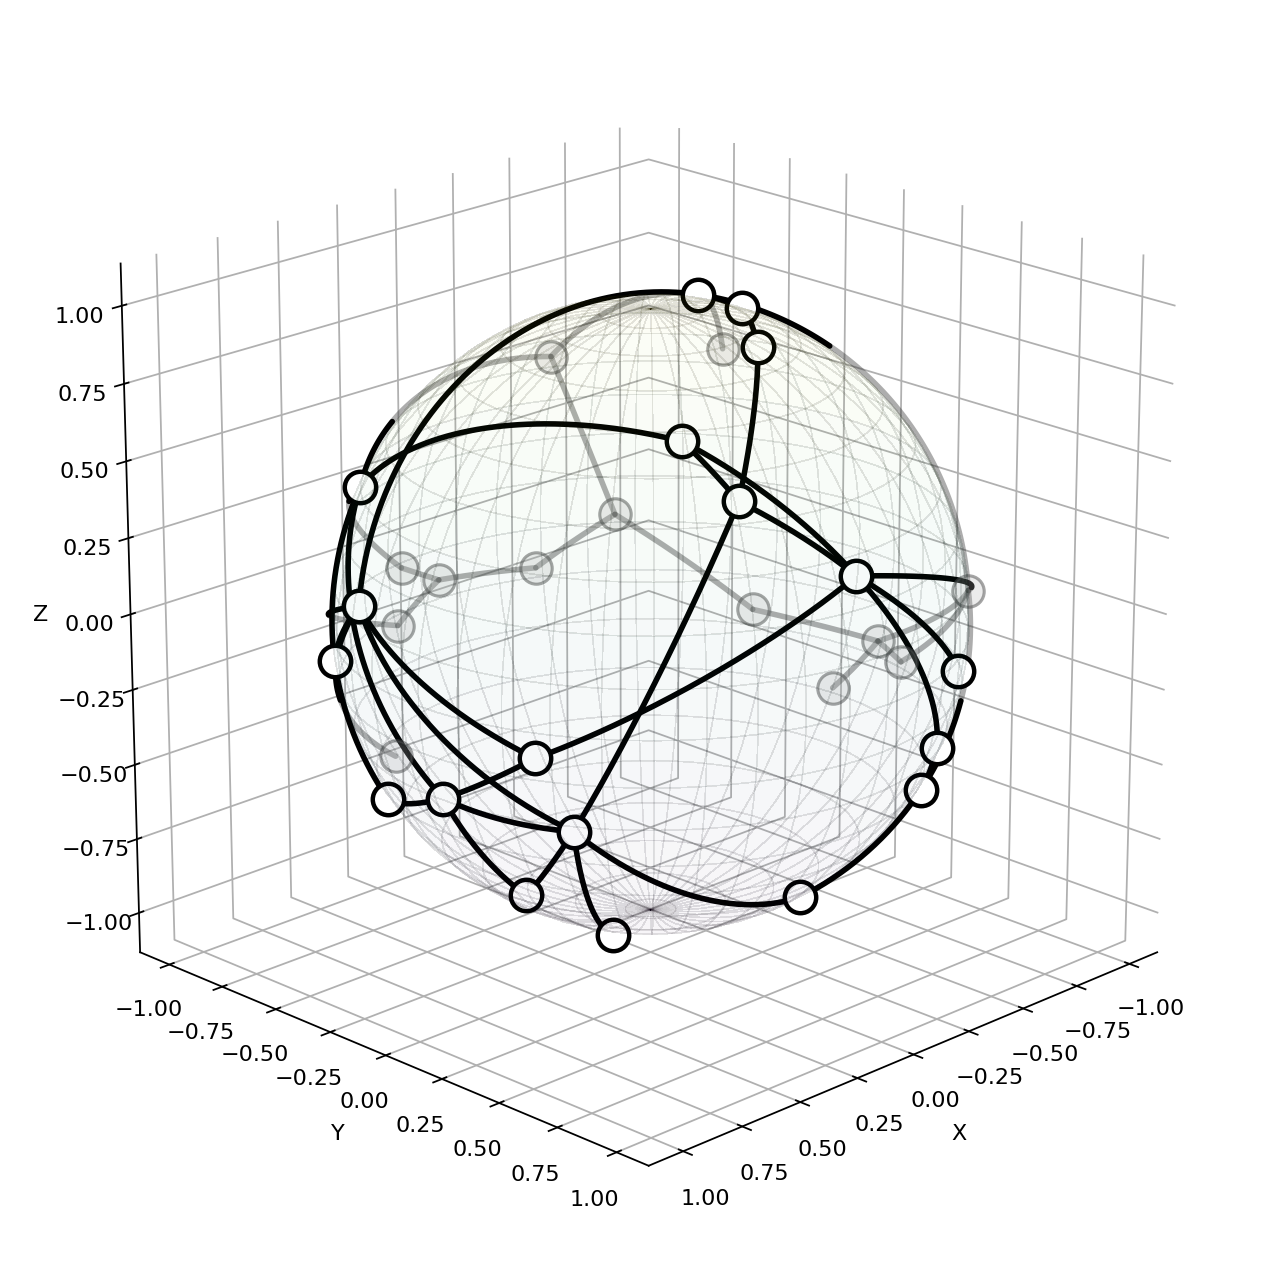

In [7]:
Q_r = np.random.randn(2000,32)
# Example call (assuming you have Q, W, G, action_indices defined)
def edges_from_adjacency(adj_matrix):
    n = adj_matrix.shape[0]
    edges = []
    action_idx = 0
    action_indices = {}
    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle
            if adj_matrix[i][j] != 0:
                edges.append((i, j))
                action_indices[(i, j)] = action_idx
                action_idx += 1
                edges.append((j, i))
                action_indices[(j, i)] = action_idx
                action_idx += 1
    return edges, action_indices
adj_t = nx.to_numpy_array(G)
edges, action_indices = edges_from_adjacency(adj_t)
fig, ax = run_t_sne_3d_raw(
    Q, G, action_indices, # Change Q to Q_r to see by initialization what does the cognitive map looks like
    perp=5, r=1.0,
    azim=45, elev=20, show_labels=True
)



=== Precompute Dijkstra baseline once ===
Graph diameter: 6, Dijkstra mean over all pairs: 3.030 (std 1.140)

=== Sweeping episodes-per-node and evaluating EN over multiple runs ===

--- Run 1/10 ---
episodes/node=   1 | total=    32 | ENA mean=3.994 | Graded ENA mean=3.704
episodes/node=   2 | total=    64 | ENA mean=3.386 | Graded ENA mean=3.277
episodes/node=   5 | total=   160 | ENA mean=3.160 | Graded ENA mean=3.105
episodes/node=  10 | total=   320 | ENA mean=3.095 | Graded ENA mean=3.068
episodes/node=  20 | total=   640 | ENA mean=3.052 | Graded ENA mean=3.049
episodes/node=  50 | total=  1600 | ENA mean=3.055 | Graded ENA mean=3.037
episodes/node= 100 | total=  3200 | ENA mean=3.056 | Graded ENA mean=3.037
episodes/node= 200 | total=  6400 | ENA mean=3.060 | Graded ENA mean=3.044
episodes/node= 500 | total= 16000 | ENA mean=3.065 | Graded ENA mean=3.049
episodes/node=1000 | total= 32000 | ENA mean=3.065 | Graded ENA mean=3.047

--- Run 2/10 ---
episodes/node=   1 | total=    

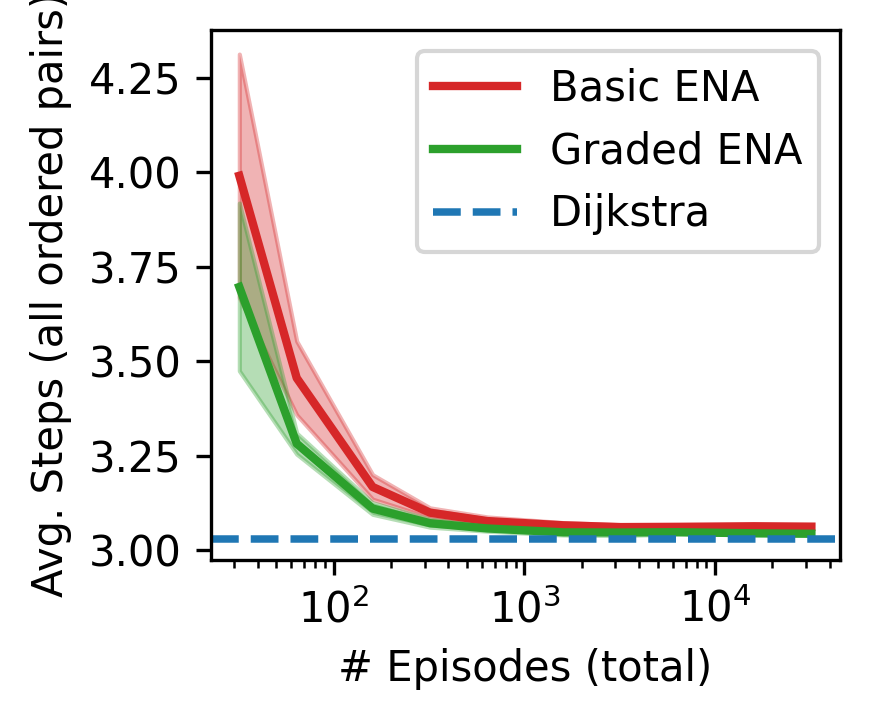

In [10]:
# === 10-run ensemble over different sampled trajectories ===
import numpy as np
import matplotlib.pyplot as plt

# === Add below your current MAIN (after you've built G) ===
import matplotlib.pyplot as plt

def all_pairs_shortest_lengths(G: nx.Graph) -> Dict[Tuple[int,int], int]:
    """All ordered pairs (s,t), s!=t, shortest-path lengths."""
    apsp = dict(nx.all_pairs_shortest_path_length(G))
    dj = {}
    for s, d in apsp.items():
        for t, L in d.items():
            if s != t:
                dj[(s, t)] = L
    return dj

def en_steps_all_pairs_with_penalty(
    G: nx.Graph, corr: torch.Tensor, max_steps: int, penalty_steps: int
) -> np.ndarray:
    """
    Returns array of length N*(N-1) with EN steps for all ordered pairs.
    If EN fails, assign 'penalty_steps' (graph diameter).
    """
    n = G.number_of_nodes()
    out = np.empty(n*(n-1), dtype=np.float32)
    k = 0
    for s in range(n):
        for t in range(n):
            if s == t:
                continue
            success, steps = en_plan_single(G, corr, s, t, max_steps, False)
            out[k] = steps if success else penalty_steps
            k += 1
    return out

print("\n=== Precompute Dijkstra baseline once ===")
dj_lengths = all_pairs_shortest_lengths(G)
diameter   = max(dj_lengths.values())                  # longest possible shortest path
dj_all     = np.array(list(dj_lengths.values()), dtype=np.float32)
dj_mean    = float(dj_all.mean())
dj_std     = float(dj_all.std(ddof=0))
print(f"Graph diameter: {diameter}, Dijkstra mean over all pairs: {dj_mean:.3f} (std {dj_std:.3f})")

# Grid of episodes-per-node to test (adjust as you like)
EPISODES_PER_NODE_GRID = [1,2,5,10,20,50,100,200,500,1000]
num_runs = 10

# Preallocate: rows = runs, cols = len(grid)
# en_means_runs   = np.zeros((num_runs, len(EPISODES_PER_NODE_GRID)), dtype=np.float32)  # distance-aware EN
en_o_means_runs = np.zeros((num_runs, len(EPISODES_PER_NODE_GRID)), dtype=np.float32)  # original EN
en_g_means_runs = np.zeros((num_runs, len(EPISODES_PER_NODE_GRID)), dtype=np.float32)  # original EN

# We'll also keep the x axis (total episodes) once
tot_episodes = np.array([cfg.num_nodes * ep for ep in EPISODES_PER_NODE_GRID], dtype=np.int32)

base_seed = getattr(cfg, "seed", 0) if getattr(cfg, "seed", None) is not None else 0

print("\n=== Sweeping episodes-per-node and evaluating EN over multiple runs ===")
for run_idx in range(num_runs):
    print(f"\n--- Run {run_idx+1}/{num_runs} ---")
    for j, ep_per_node in enumerate(EPISODES_PER_NODE_GRID):
        # IMPORTANT: vary the seed per run so trajectories differ
        tmp_cfg = Config(
            num_nodes=cfg.num_nodes,
            edge_prob=cfg.edge_prob,
            walk_length=8,
            traj_per_start=ep_per_node,
            max_steps_plan=cfg.max_steps_plan,
            seed=base_seed + 1000*run_idx + j  # different seed per (run,grid point)
        )

        trajectories = generate_trajectories(G, tmp_cfg)
        Q      = build_Q(trajectories, tmp_cfg.num_nodes)
        corr_o = columnwise_dot_corr_matrix(Q)
#         corr   = build_exp_decay_similarity(
#             trajectories, num_nodes=cfg.num_nodes, gamma=0.3, include_self=False
#         )
        corr_g = build_centered_gaussian_similarity(trajectories, num_nodes=cfg.num_nodes, include_self=False)



        # EN steps over all ordered pairs; failures penalized by graph diameter
#         en_steps   = en_steps_all_pairs_with_penalty(
#             G, corr,   max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
#         )
        en_steps_o = en_steps_all_pairs_with_penalty(
            G, corr_o, max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
        )
        en_steps_g = en_steps_all_pairs_with_penalty(
            G, corr_g, max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
        )

#         en_mean   = float(en_steps.mean())
        en_o_mean = float(en_steps_o.mean())
        en_g_mean = float(en_steps_g.mean())
        
#         en_means_runs[run_idx, j]   = en_mean
        en_o_means_runs[run_idx, j] = en_o_mean
        en_g_means_runs[run_idx, j] = en_g_mean

        print(
            f"episodes/node={ep_per_node:4d} | total={tot_episodes[j]:6d} | "
            f"ENA mean={en_o_mean:.3f} | Graded ENA mean={en_g_mean:.3f}"
        )

# Aggregate across runs: mean-of-means and std-of-means (shaded)
# m_da = en_means_runs.mean(axis=0)                 # distance-aware mean across runs
# sd_da = en_means_runs.std(axis=0, ddof=0)         # std of the run means

m_en = en_o_means_runs.mean(axis=0)               # original EN mean across runs
sd_en = en_o_means_runs.std(axis=0, ddof=0)       # std of the run means

m_gr = en_g_means_runs.mean(axis=0) 
sd_gr = en_g_means_runs.std(axis=0, ddof=0)  




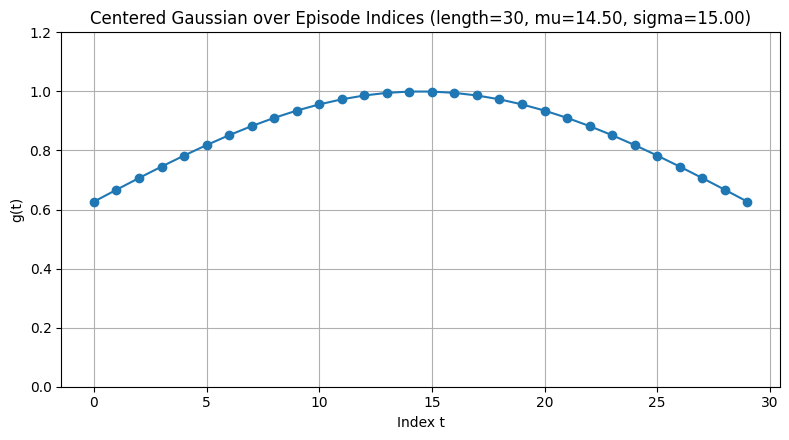

In [12]:
# Draw the Gaussian over indices for episode length = 30
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 30
mu = (m - 1) / 2.0     # center at the middle of the episode
sigma = m / 2.0        # ensures 2*sigma == episode length

t = np.arange(m)
g = np.exp(-0.5 * ((t - mu) / max(sigma, 1e-12)) ** 2)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(t, g, marker='o')
plt.title(f'Centered Gaussian over Episode Indices (length={m}, mu={mu:.2f}, sigma={sigma:.2f})')
plt.xlabel('Index t')
plt.ylabel('g(t)')
plt.grid(True)
plt.ylim(0,1.2)
plt.tight_layout()



=== Precompute Dijkstra baseline once ===
Graph diameter: 6, Dijkstra mean over all pairs: 3.030 (std 1.140)

=== Sweeping episodes-per-node and evaluating EN over multiple runs ===

--- Run 1/10 ---
episodes/node=1000 | length=     2 | EN mean=3.538 | Graded EN mean=3.538
episodes/node=1000 | length=     3 | EN mean=3.113 | Graded EN mean=3.107
episodes/node=1000 | length=     4 | EN mean=3.039 | Graded EN mean=3.035
episodes/node=1000 | length=     5 | EN mean=3.042 | Graded EN mean=3.033
episodes/node=1000 | length=     6 | EN mean=3.047 | Graded EN mean=3.037
episodes/node=1000 | length=     7 | EN mean=3.064 | Graded EN mean=3.038
episodes/node=1000 | length=     8 | EN mean=3.056 | Graded EN mean=3.037
episodes/node=1000 | length=     9 | EN mean=3.068 | Graded EN mean=3.050
episodes/node=1000 | length=    10 | EN mean=3.066 | Graded EN mean=3.051

--- Run 2/10 ---
episodes/node=1000 | length=     2 | EN mean=3.538 | Graded EN mean=3.538
episodes/node=1000 | length=     3 | EN m

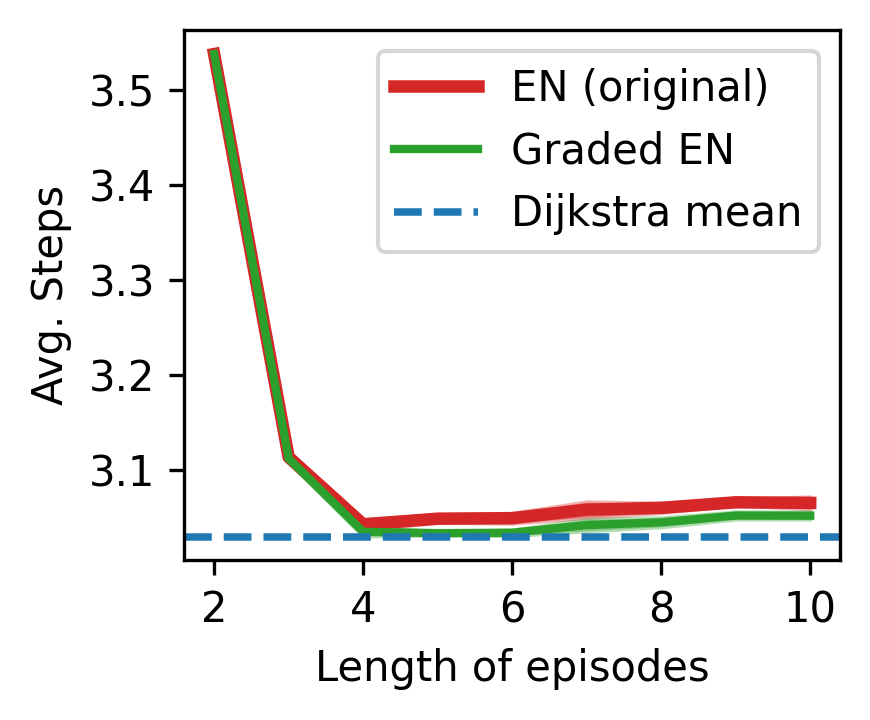

In [15]:
# === 10-run ensemble over different sampled trajectories ===
import numpy as np
import matplotlib.pyplot as plt

print("\n=== Precompute Dijkstra baseline once ===")
dj_lengths = all_pairs_shortest_lengths(G)
diameter   = max(dj_lengths.values())                  # longest possible shortest path
dj_all     = np.array(list(dj_lengths.values()), dtype=np.float32)
dj_mean    = float(dj_all.mean())
dj_std     = float(dj_all.std(ddof=0))
print(f"Graph diameter: {diameter}, Dijkstra mean over all pairs: {dj_mean:.3f} (std {dj_std:.3f})")

# Grid of episodes-per-node to test (adjust as you like)
EPISODES_PER_NODE_GRID = 100#[1,2,5,10,20,50,100,200,500,1000,2000]
EPISODES_LENGTH = np.arange(2,11)
num_runs = 10

# Preallocate: rows = runs, cols = len(grid)
# en_means_runs   = np.zeros((num_runs, len(EPISODES_LENGTH)), dtype=np.float32)  # distance-aware EN
en_o_means_runs = np.zeros((num_runs, len(EPISODES_LENGTH)), dtype=np.float32)  # original EN
en_g_means_runs = np.zeros((num_runs, len(EPISODES_LENGTH)), dtype=np.float32)  # original EN

# We'll also keep the x axis (total episodes) once
tot_episodes = np.array([cfg.num_nodes * EPISODES_PER_NODE_GRID], dtype=np.int32)

base_seed = getattr(cfg, "seed", 0) if getattr(cfg, "seed", None) is not None else 0

print("\n=== Sweeping episodes-per-node and evaluating EN over multiple runs ===")
for run_idx in range(num_runs):
    print(f"\n--- Run {run_idx+1}/{num_runs} ---")
    for j, ep_length in enumerate(EPISODES_LENGTH):
        # IMPORTANT: vary the seed per run so trajectories differ
        tmp_cfg = Config(
            num_nodes=cfg.num_nodes,
            edge_prob=cfg.edge_prob,
            walk_length=ep_length,
            traj_per_start=EPISODES_PER_NODE_GRID,
            max_steps_plan=cfg.max_steps_plan,
            seed=base_seed + 123*run_idx + j  # different seed per (run,grid point)
        )

        trajectories = generate_trajectories(G, tmp_cfg)
        Q      = build_Q(trajectories, tmp_cfg.num_nodes)
        corr_o = columnwise_dot_corr_matrix(Q)
#         corr   = build_exp_decay_similarity(
#             trajectories, num_nodes=cfg.num_nodes, gamma=0.3, include_self=False
#         )
        corr_g = build_centered_gaussian_similarity(trajectories, num_nodes=cfg.num_nodes, include_self=False)

        # EN steps over all ordered pairs; failures penalized by graph diameter
#         en_steps   = en_steps_all_pairs_with_penalty(
#             G, corr,   max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
#         )
        en_steps_o = en_steps_all_pairs_with_penalty(
            G, corr_o, max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
        )
        en_steps_g = en_steps_all_pairs_with_penalty(
            G, corr_g, max_steps=tmp_cfg.max_steps_plan, penalty_steps=diameter
        )

#         en_mean   = float(en_steps.mean())
        en_o_mean = float(en_steps_o.mean())
        en_g_mean = float(en_steps_g.mean())
        
#         en_means_runs[run_idx, j]   = en_mean
        en_o_means_runs[run_idx, j] = en_o_mean
        en_g_means_runs[run_idx, j] = en_g_mean

        print(
            f"episodes/node={ep_per_node:4d} | length={EPISODES_LENGTH[j]:6d} | "
            f"EN mean={en_o_mean:.3f} | Graded EN mean={en_g_mean:.3f}"
        )

# Aggregate across runs: mean-of-means and std-of-means (shaded)
# m_da = en_means_runs.mean(axis=0)                 # distance-aware mean across runs
# sd_da = en_means_runs.std(axis=0, ddof=0)         # std of the run means

m_en = en_o_means_runs.mean(axis=0)               # original EN mean across runs
sd_en = en_o_means_runs.std(axis=0, ddof=0)       # std of the run means

m_gr = en_g_means_runs.mean(axis=0) 
sd_gr = en_g_means_runs.std(axis=0, ddof=0)  

# --- Plot ---
plt.figure(figsize=(3,2.5),dpi=300)
# Original EN: curve + shaded "std of means" band

plt.plot(EPISODES_LENGTH, m_en, linewidth=3, label="EN (original)",c='tab:red')
plt.fill_between(EPISODES_LENGTH, m_en - sd_en, m_en + sd_en,color='tab:red', alpha=0.35)
# Dist-aware EN: curve + shaded "std of means" band
# plt.plot(EPISODES_LENGTH, m_da, linewidth=2, label="Dist-aware EN",c='tab:green')
# plt.fill_between(EPISODES_LENGTH, m_da - sd_da, m_da + sd_da,color='tab:green', alpha=0.35)

# Graded EN:
plt.plot(EPISODES_LENGTH, m_gr, linewidth=2, label="Graded EN",c='tab:green')
plt.fill_between(EPISODES_LENGTH, m_gr - sd_gr, m_gr + sd_gr,color='tab:green', alpha=0.35)


# Dijkstra baseline (independent of episodes)
plt.axhline(dj_mean, linestyle="--", linewidth=1.8, label="Dijkstra mean")
# plt.fill_between(EPISODES_LENGTH, m_dij - sd_dif, m_dij + sd_dif, alpha=0.15,color='black')
# plt.ylim(2.92,3.2)
plt.xticks([2,4,6,8,10])
plt.xlabel("Length of episodes")
plt.ylabel("Avg. Steps")
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()